# Ecommerce Insights for Marketing Decisions
**Data Description:** The dataset includes purchase details on an ecommerce platform. Orer details include invoice number, invoice date, product code and description, order quantity, unit price, customer id, customer country, and channel that direct the sales.

**Objective:** The ultimate goal is to get valuable insights into customer profiles so that the company can make appropriate promotion efforts towards specific groups of customers to drive sales. In order to meet with this objective, I would perform the following analyses: <br/>
- Measure Important Ecommerce Metrics
- Define Customer Clusters
- Predict the Possibility of Repurchase Within 3 Months

### Cleaning the Dataset
First, I cleaned the dataset and understood characteristics of the dataset to have appropriate preprocessing ways.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime

from sklearn.model_selection import train_test_split  
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
# Import data and show sample data
data = pd.read_csv("ecommerce_data.csv")
print(data.shape)
data.head(2)

(541909, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,channel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Email
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Email


In [3]:
# Check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   channel      541909 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 37.2+ MB


Two columns of `Description` and `CustomerID` have null values. Null values in `Description` columns can be ignored because they can be matched with `StockCode`. Concerning `CustomerID`, though percentage of null values in this column is 25% - a high rate, null values have to be removed for analyses that utilize this information. Values in this column cannot be replaced or guessed using any methods.

I also checked for duplicates in the dataset. Typically, in a cart on an ecommerce platform, customers cannot add two lines for the same product. However, in this dataset, over 5,000 order lines have all the same details including invoice information, product code, and order quantity, and another 5,000 order lines have the same invoice information, and product code (but different order quantity). With limited information on how the data is extracted from system, I would not remove any duplicates and proceed with all the data.

As can be seen from the information above, `InvoiceDate` and `CustomerID` have wrong data format - should be datetime and string format respectively. I would convert data type of these two columns.

In [4]:
# Format InvoiceDate as datetime and CustomerID as string
# Only convert non-null CustomerID values to string
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['CustomerID'] = data['CustomerID'].where(data['CustomerID'].isnull(), data['CustomerID'].astype(str))

In [5]:
# Check selected period in the dataset
print("Period range is from",data['InvoiceDate'].min(),"to", data['InvoiceDate'].max())

# Statistics description of numeric variables
data.describe()

Period range is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


By inspecting the data, I found some noticeable points to discuss as below: 

- A number of order lines has `UnitPrice` being 0. Based on description, these seem to be invoices to clear damaged products or so, which means that they should be treated as cost, not revenue reduction. Some order lines have customer id and can possibly be promotional products added for free for several orders. These order lines add no value to revenue or customer analysis and thus can be removed.
- Lots of order lines have the following `StockCode` and `Description`. Those with codes as `D` are discounts and treated as revenue reduction for customers and those with codes as `PADS` are product sales; thus, these lines can be kept. Remaining lines are not customer purchase and thus not revenue and should be removed before analysis. For example, bad debt adjustment is company's expense; carriage fees can be charged to customers first (those with positive quantities) and then paid to carriers (lines with negative quantities). Those that refer to customer purchase or returns have `StockCode` starting with an integer. <br/>

|StockCode|Description|
|---|---|
|AMAZONFEE|AMAZON FEE|
|B|Adjust bad debt|
|BANK CHARGES|Bank Charges|
|C2|CARRIAGE|
|CRUK|CRUK Commission|
|D|Discount|
|DCGS...|Various description|
|DOT|DOTCOM POSTAGE|
|gift_0001_..|Voucher|
|M|Manual|
|PADS|PADS TO MATCH ALL CUSHIONS|
|POST|POSTAGE|
|S|SAMPLES|

- Among order lines with negative quantities and non-zero `UnitPrice`, those with product codes are returns. As for analysis relating to revenue by period, returns should be netoff with the original order lines so that revenues would be reflected in the correct periods; and, returns for orders placed before the selected period should be removed. Regarding analysis in which customers' frequency of purchase is concerned, original orders would be counted while returns won't. However, within the scope of this analysis, the netoff cannot be done correctly. The reason is that there is no clue on which is the original purchase for the returns. A customer can make multiple purchases for 1 item in different months and then make one return - no clue which original purchase to netoff with the return. After removing order lines that are not revenues as mentioned above, total generated revenue for the whole period is about 9.7 million USD while the returned amount is 478,000 USD, accounting for insignificant 5%. Thus, I will keep the returns data.

In [6]:
# Remove order lines that refer to cost
## Remove lines with unit prices = 0
data = data[data['UnitPrice']!=0]
## Drop order lines that are not customer purchases
digits = []
for i in range(0,10):
    digits.append(str(i))
data = data[(data['StockCode']== 'PADS') | (data['StockCode']== 'D') | (data['StockCode'].str[0].isin(digits))]
## Sort dataset with InvoiceDate in an ascending order
data = data.sort_values('InvoiceDate').reset_index().drop('index',axis=1)

# Check new data dimension
data.shape

(536509, 9)

### A/ Measure Important Ecommerce Metrics
To understand more about the business and measure its performance, I would explore the dataset following important metrics of an ecommerce. (Important metrics can be found [here.](https://www.bigcommerce.com/blog/ecommerce-metrics))

Revenue will be aggregated by month for some analysis. The latest date in the dataset is 2011/12/09, so December 2011 will be removed from the dataset because data is not complete for this month. Also, we can use 12 months from December 2010 to November 2011 to analyze 1-year performance.

In [7]:
# Add a column for revenue generated by each order line
data['Revenue'] = data['UnitPrice']*data['Quantity']
# Add a column for month-year value of invoice
data['Period'] = data['InvoiceDate'].dt.to_period('M')

In [8]:
# Copy the data and remove December 2011
data_rev = data.copy()
data_rev = data[data['Period'] < '2011-12']
data_rev.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,channel,Revenue,Period
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Email,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Email,20.34,2010-12


#### Revenue Growth
First, I would take a look into how much revenue has grown over time. To have a better view, I separated monthly purchase amounts and returns amounts.

In [ ]:
data_rev['Status'] = data_rev['Quantity'].apply(lambda x: 'Purchase' if x >=0 else 'Returns')
data_rev[data_rev['StockCode']=='D'] = data_rev[data_rev['StockCode']=='D'].replace('Returns','Purchase')
data_rev_month = pd.pivot_table(data_rev, values = 'Revenue', index = 'Period', columns = 'Status',aggfunc=np.sum
                     ).reset_index().set_index('Period') 
data_rev_month['Returns'] = -data_rev_month['Returns']

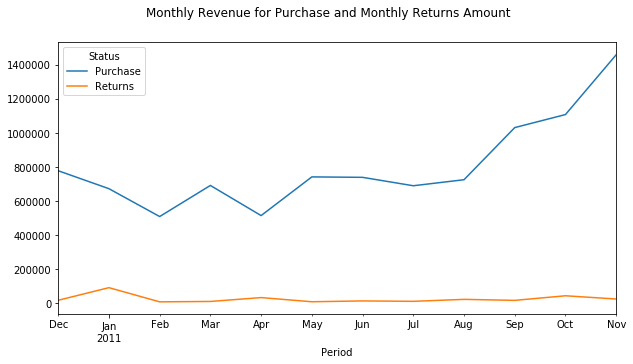

In [10]:
ax = data_rev_month[['Purchase','Returns']].plot(figsize=(10, 5))
fig = ax.get_figure()
fig.suptitle('Monthly Revenue for Purchase and Monthly Returns Amount')
plt.show()

It can be seen that there is minimal variations in monthly returns. In general, there was an upwards trend in revenue growth. However, monthly revenue dropped significantly in Feb and Apr before it bounced back in May, stabilized for two months and grew from Aug onwards. <br/>
There are many possible reasons for the drop in Feb and Apr that need a more thorough analysis. That can stem from inventory shortage, discount policies on cheaper products to attract more customers, etc.

#### Returns Rate
To measure the percentage of returns volumn per month. As can be seen from the revenue growth graph, returns remained stable over the time. Even though with this dataset, we couldn't identify the correct period that the returns belong to (the returns can be in March, but for Jan purchase, and thus would belong to Jan, not Mar), it's still reasonable for us to just use the raw returns data for analysis without modifying the period.

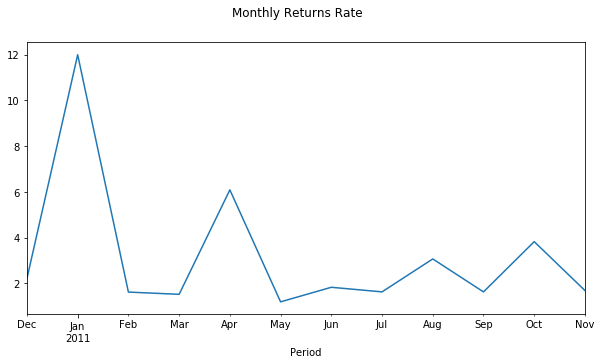

In [76]:
# Check returns rate per month
data_rev_month['ReturnRate'] = data_rev_month['Returns']*100/(data_rev_month['Returns']+data_rev_month['Purchase'])
ax = data_rev_month['ReturnRate'].plot(figsize=(10, 5))
fig = ax.get_figure()
fig.suptitle('Monthly Returns Rate')
plt.show()

In 2016, a [report](https://www.cnbc.com/2016/12/16/a-260-billion-ticking-time-bomb-the-costly-business-of-retail-returns.html) from CNBC stated that ecommerce returns rate was usually as high as 30%. This company's returns rate was low throughout the whole period. It peaked in Jan 2011 and dropped significantly in the following months. However, in order to indicate if this is a good figure or not, it's necessary to look in the company's returns policy. Also, in 2011, ecommerce has still not as developed as it was in 2016; thus, returns rate might have been a lot lower. 

#### Revenue Source
This is to see which channel could drive most sales for the company.

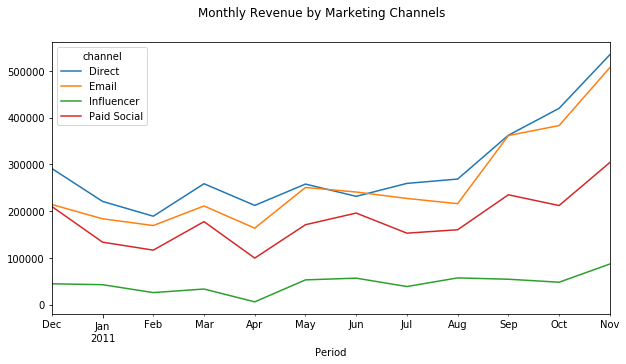

In [77]:
data_rev_channel = pd.pivot_table(data_rev, values = 'Revenue', index = 'Period', columns = 'channel',aggfunc=np.sum
                     ).reset_index().set_index('Period') 
ax = data_rev_channel.plot(figsize=(10, 5))
fig = ax.get_figure()
fig.suptitle('Monthly Revenue by Marketing Channels')
plt.show()

Based on the graph, it is noted that Direct sales and sales from Email grew significantly during the period while sales from paid social platforms and influencers remained stable. 

#### Revenue by Country
This is to check what are top 10 countries with highest sales.

In [78]:
data_rev_country = data_rev.groupby(['Country'])['Revenue'].sum().reset_index().sort_values('Revenue',ascending=False).reset_index().drop('index',axis=1)
data_rev_country['Percentage'] = data_rev_country['Revenue']*100/data_rev_country['Revenue'].sum()
data_rev_country.iloc[:10]

,Country,Revenue,Percentage
0,United Kingdom,7.897009e+06,84.502654
1,Netherlands,2.715451e+05,2.905693
2,EIRE,2.521059e+05,2.697682
3,Germany,1.939637e+05,2.075526
4,France,1.757721e+05,1.880865
5,Australia,1.369900e+05,1.465874
6,Switzerland,5.250535e+04,0.561838
7,Spain,5.152177e+04,0.551313
8,Japan,3.553672e+04,0.380264
9,Belgium,3.538253e+04,0.378614


It's clear from the table that UK is the main country that the ecommerce targets. Revenue from other countries accounted for just a small percentage. Based on the summary, the company may do further analysis to see if they can do more promotion in countries like the Netherlands, EIRE - 2nd and 3rd on the list - to get more customers.

#### Average Order Value (AOV)
To check monthly average value per order.

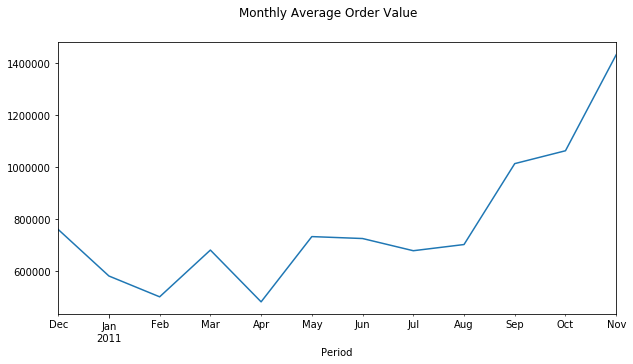

In [162]:
data_avg_order = pd.pivot_table(data_avg_order, values = ['Revenue','InvoiceNo'], index = 'Period',aggfunc={
    'Revenue': np.sum, 'InvoiceNo': 'count'}).reset_index().set_index('Period')
data_avg_order['AvgValue'] = data_avg_order['Revenue']/data_avg_order['InvoiceNo']
ax = data_avg_order['AvgValue'].plot(figsize=(10, 5))
fig = ax.get_figure()
fig.suptitle('Monthly Average Order Value')
plt.show()

The trend in monthly AOV did not go with that in monthly revenue. The figure in April was the lowest at 330 while the peak in Sep was 477. Some points can be drawn: In April, it seems that less customers placed orders and AOV decreased significantly, leading to a large drop in sales; in June and Jul, sales remained unchanged while AVO increased, possibly meaning that less customers placed orders; in Oct & Nov, AOV decreased while revenue still grew - this can be because the company offered lots of promotions in this period and could attract more customers or more orders from existing customers.

#### New Customer Ratio
To see how well the ecommerce could attract new customers.

In [81]:
# Create a column to specify is purchase is from new or existing customer.
# Note that this cannot be done for Dec 2010 because that's the first month in selected period.
# Only invoice with customerid information can be used.
data_rev_cus = data_rev.dropna(subset = ['CustomerID'])
## Find first purchase period
firstpurchase = data_rev_cus.groupby('CustomerID')['Period'].min().reset_index()
firstpurchase.columns = ['CustomerID', 'FirstPurchasePeriod']
## Merge with first purchase period
data_rev_cus = pd.merge(data_rev_cus,firstpurchase, on = 'CustomerID')
## Define UserType
data_rev_cus['UserType'] = 'New'
data_rev_cus.loc[data_rev_cus['Period']>data_rev_cus['FirstPurchasePeriod'],'UserType'] = 'Existing'

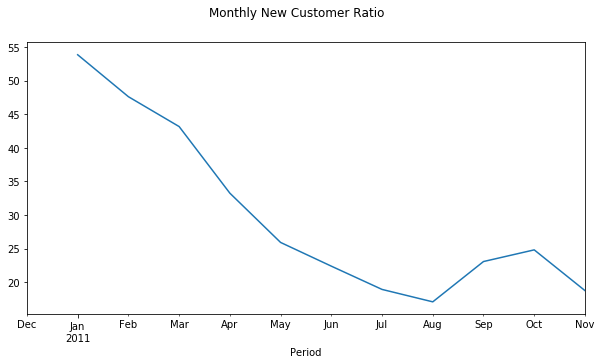

In [82]:
# Count new customers and existing customers monthly and find out new customer ratio
new_customer = pd.pivot_table(data_rev_cus, values = 'CustomerID', index = 'Period', columns = 'UserType',
                              aggfunc=pd.Series.nunique)
new_customer['NewCustomerRatio'] = new_customer['New']*100/(new_customer['New']+new_customer['Existing'])
ax = new_customer['NewCustomerRatio'].plot(figsize=(10, 5))
fig = ax.get_figure()
fig.suptitle('Monthly New Customer Ratio')
plt.show()

Assuming all the customers in the first month of the selected period - Dec 2010 - are new, we have the new customer ratio throughout the whole period as above. The company couldn't well attract new customers. The ratio plummeted from the beginning till Aug and recovered slightly in Sep & Oct, but again decreased in Nov to just above the August low.

#### Customer Retention Rate
To see how well the ecommerce could retain customers.

In [83]:
# Group revenue by customer per period 
rev_by_customer = data_rev_cus.groupby(['CustomerID','Period'])['Revenue'].sum().astype(int).reset_index()
# Check if customer placed order in each period
monthly_purchase = pd.crosstab(rev_by_customer['CustomerID'],rev_by_customer['Period'])
monthly_purchase.head(2)

Period,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
CustomerID,,,,,,,,,,,,
12346.0,0,1,0,0,0,0,0,0,0,0,0,0
12347.0,1,1,0,0,1,0,1,0,1,0,1,0


In [106]:
# Create a dataframe with monthly customers and retained customers to calculate retention rate
# Monthly retained customers are those to place orders in the previous month
periods = list(monthly_purchase.columns.astype(str))
retention_rate = pd.DataFrame(index = periods[1:])
## Total monthly customers
for i in periods[1:]:
    retention_rate.loc[i,'TotalMonthlyCustomers'] = monthly_purchase[i].sum()
## Total retained customers
for i in range(1,len(periods)):
    j = i - 1
    retention_rate.loc[periods[i],'TotalRetainedCustomers'] = monthly_purchase[(monthly_purchase[periods[j]]>0) & (monthly_purchase[periods[i]])][periods[i]].sum()
## Retention Rate
retention_rate['RetentionRate'] = retention_rate['TotalRetainedCustomers']*100/retention_rate['TotalMonthlyCustomers']

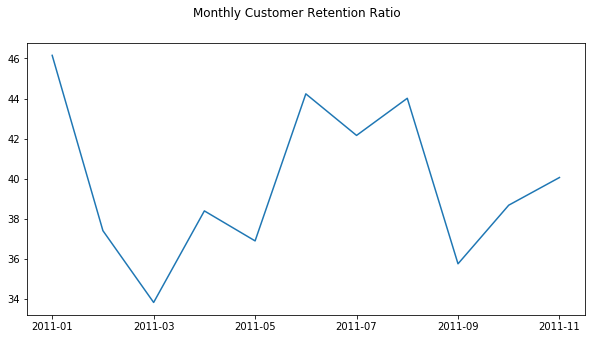

In [108]:
ax = retention_rate['RetentionRate'].plot(figsize=(10, 5))
fig = ax.get_figure()
fig.suptitle('Monthly Customer Retention Ratio')
plt.show()

Customer retention rate of this company varied in the range between 34% and 44% throughout the period. WebRetailer [reported](https://www.webretailer.com/b/ecommerce-returns/) that ecommerce with 40% repeat purchasers generate 50% higher revenue than those with 10% repeat customers. Thus, the company should make more efforts to get customers to return.

#### Summary
Overall, performance of the company in the first six months of 2011 was not so good, but could recover in the second half of the year. Based on the metrics, there are some insights as below:
- Direct and emails were the main revenue sources of the company and made equal contribution. More email marketing efforts should thus be made.
- UK was still the dominant market of the company with sales from this country accounting for 84%. Netherlands and EIRE came next; the company may do further analysis to see if they can do more promotion in these countries to get more potential sales.
- Returns rate was low throughout the whole period; sales only grew from Aug. The company may review its returns policy to see if the low returns rate resulted from a strict return policy because a strict return policy may hurt the company's revenues.
- Retention rate was good but new customer ratio decreased significantly. More efforts should be made to increase retention rate from over 30% to 40% and to increase customer ratio also.

### B/ Define Customer Clusters
No companies treat all customers the same way. In order to drive more sales growth, the company must understand their customers to have appropriate approaches towards the customers. 

In this section, I would define different customer clusters to customize promotional strategies towards each customer group.

**Approach:** I would use RFM analysis, which is a popular model for customer segmentation. More details on this model can be found [here](https://www.barilliance.com/rfm-analysis/). "*SEGMENTATION based on RFM (Recency, Frequency, and Monetary) has been in use for over 50 years especially by direct marketers to target a subset of their customers, save marketing costs, and improve profits.*"  <br/>
Overall, RFM model stands for recency, frequency, and monetary value. I would define customer clusters based on their last purchase date, their frequency of purchase, and the total order value of their orders. I would first assign relevant scores for each criteria to all the customers.

In this analysis, I would use the full dataset instead of a cutoff at November end as in section A. Order lines with no `customerID` would be removed. Also, note that the dataset includes returns, but recency and frequency applies to original purchases only, not including returns.

In [110]:
# Remove order lines with null CustomerID
data = data.dropna(subset = ['CustomerID'])
# Extract original purchase into a different dataframe
purchases = data[data['Quantity'] >0]

In [132]:
# Construct the user dataframe
users_df = pd.DataFrame(purchases['CustomerID'].unique())
users_df.columns = ['CustomerID']

In [133]:
# Check recency - the duration from last purchase day
last_purchase = purchases.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID','LastPurchaseDate']
last_purchase['Recency'] = (purchases['InvoiceDate'].max() - last_purchase['LastPurchaseDate']).dt.days
users_df = pd.merge(users_df, last_purchase[['CustomerID','Recency']], on='CustomerID')

In [134]:
# Check frequency - number of times a customer places orders within the period
frequency = purchases.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID','Frequency']
users_df = pd.merge(users_df, frequency, on='CustomerID')

In [138]:
# Check monetary value - total order values throughout the whole period for each customer
# Note this includes returns and discounts
monetary = data.groupby('CustomerID')['Revenue'].sum().reset_index()
users_df = pd.merge(users_df, monetary, on='CustomerID')
users_df.head(3)

,CustomerID,Recency,Frequency,Revenue
0,17850.0,371,34,5288.63
1,13047.0,56,9,3089.10
2,12583.0,2,15,6629.34


#### Clustering Analysis
##### Normalizing over the standard deviation 
Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. I used StandardScaler() to normalize our dataset.

In [143]:
from sklearn.preprocessing import StandardScaler

users_df_cl = users_df.copy()

X = users_df_cl.values[:,1:]
X = np.nan_to_num(X)
clus_data = StandardScaler().fit_transform(X)
clus_data

array([[ 2.78835511,  3.89751338,  0.40760101],
       [-0.35644059,  0.62273652,  0.1421217 ],
       [-0.89554842,  1.40868297,  0.5694223 ],
       ...,
       [-0.91551538, -0.42519207, -0.18727577],
       [-0.91551538, -0.42519207, -0.20328155],
       [-0.91551538, -0.42519207, -0.13482636]])

##### Modeling
First, I used Elbow method to determine the appropriate number of clusters.

C:\Users\ntkcu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


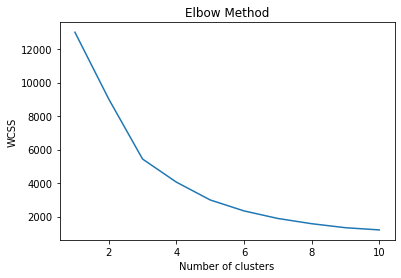

In [144]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(clus_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Based on the graph, it would be most optimal to have 3 clusters for this customer dataset.

In [145]:
# Get the cluster labels
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(clus_data)
labels = k_means.labels_
print(labels)

[2 0 0 ... 0 0 0]


In [146]:
# Sssign the labels to each row in dataframe.
users_df_cl["Cluster"] = labels
users_df_cl.head(2)

,CustomerID,Recency,Frequency,Revenue,Cluster
0,17850.0,371,34,5288.63,2
1,13047.0,56,9,3089.10,0


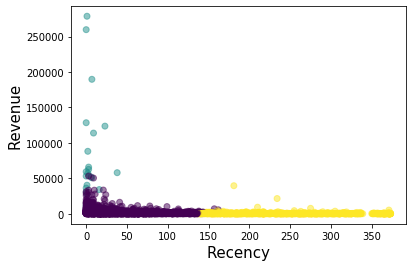

In [160]:
# Distribution of customers based on Revenue and Recency
plt.scatter(X[:,0], X[:,2], c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Recency', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.show()

Customers who recently placed orders generated high revenues for the company.

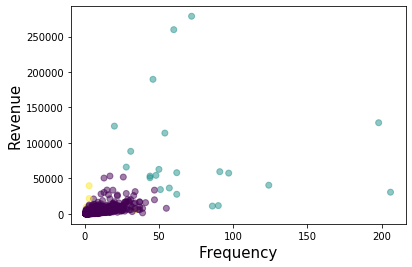

In [161]:
# Distribution of customers based on Revenue and Frequency
plt.scatter(X[:,1], X[:,2], c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.show()

No surprisingly, customers who frequently placed orders brought higher revenues to the company. However, there is not a linear relationship between frequency and revenues here.

##### Insights

In [147]:
# Check the centroid values by averaging the features in each cluster
users_df_cl.groupby('Cluster').mean()

,Recency,Frequency,Revenue
Cluster,,,
0,40.233633,4.676078,1826.210072
1,5.409091,73.681818,83412.575455
2,245.775023,1.570248,517.849735


By examining customers in each cluster and the centroid values of each cluster, I got three clusters as below:
- *First cluster (cluster 0):* Customers in this group are relatively recent customers and purchase infrequently with average purchase values.
- *Second cluster (cluster 1):* Recent customers who purchase frequently with total high value.
- *Third cluster (cluster 2):* These customers purchase rarely and bring low purchase value to the company. They have made last purchase long time ago.

#### Summary 
Clustering analysis resulted in a clear grouping of customers with three groups as below:
- Frequent, recent customers who make total high purchase value.
- Relatively recent customers who infrequently place orders with average purchase values.
- Long-standing customers who rarely purchases and generate low total purchase values.

Based on this grouping result, I suggest the company focus more promotions on the group of customers who tend to purchase frequently and bring high revenue to the company. With this grouping, the company knows how to drive promotion efforts on appropriate customers.

This clustering analysis is based on RFM Model only and thus haas some limitations. It takes into account of customer behaviors and excludes other important variables that are equally or even more important like purchased products, promotions offered, demographic information, etc.

### C/ Predict Repurchase in 3 Months
In addition to customer segmentation, to better understand customer behaviors to have appropriate approaches to drive more sales, I would build a model to predict if the customer would return to make purchase within the next 3 months.

The dataset used for this prediction excludes order lines without `CustomerID` and used data for the whole period. Only order lines with positive quantities would be used. Thus, I would use the `purchases` dataframe extracted in the previous section.

### Feature Engineering
To extract appropriate features for the prediction. 

With the information included in this dataset, some additional potential features to be extracted and considered in the maching learning model are:
- Average Order Value
- Number of Items Purchased
- How Long the Customer has been Active
- Month, WeekDay, and Hour of Purchase

Days from the latest purchase is also a potential feature. However, this feature can only be applied to existing customers. The amount of data avaialble is limited; thus, this feature is not appropriate in this case.

In [251]:
# Construct a new dataframe
df = pd.pivot_table(purchases, values = ['StockCode','Quantity','Revenue'], index = 'InvoiceNo',aggfunc={
    'Revenue': np.sum, 'Quantity': np.sum, 'StockCode': pd.Series.nunique}).reset_index()
df['AvgOrderValue'] = df['Revenue']/df['Quantity']
df = df.drop(columns=['Quantity','Revenue'])
df.columns = ['InvoiceNo','NoItemsPurchased','AvgOrderValue']
df.head(2)

,InvoiceNo,NoItemsPurchased,AvgOrderValue
0,536365,7,3.478
1,536366,2,1.850


In [252]:
# Add back InvoiceDate, CustomerID, Country, and channel
df = pd.merge(df, purchases[['InvoiceNo','InvoiceDate','CustomerID','Country','channel','Period']], on = 'InvoiceNo',how='left')
df = df.drop_duplicates(subset=['InvoiceNo'])

# Extract weekday and month information of invoices
df['Weekday'] = df['InvoiceDate'].dt.weekday 
df['Month'] = df['InvoiceDate'].dt.month
df['Hour'] = df['InvoiceDate'].dt.hour

In [253]:
# Add detail on how long the customer has been active
## Find first purchase period
firstpurchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
firstpurchase.columns = ['CustomerID', 'FirstPurchaseDate']
## Merge with first purchase period
df = pd.merge(df,firstpurchase, on = 'CustomerID')
## Add duration
df['ActiveDays'] = (df['InvoiceDate'] - df['FirstPurchaseDate']).dt.days
df = df.reset_index().drop('index',axis=1)

In [262]:
# Add status of repurchase in 3 months for each invoice
# The last invoice date will be excluded from the checking
for i in df.index:
    customerid = df.loc[i,'CustomerID']
    start = df.loc[0,'InvoiceDate']
    end = start + datetime.timedelta(days=90)
    temp = df[(df['CustomerID']==customerid) & (df['InvoiceDate']>start) & (df['InvoiceDate']<=end)]
    if temp.shape[0] > 0:
        df.loc[i,'RepurchaseStatus'] = 1 # customer did repurchase in 3 months
    else:
        df.loc[i,'RepurchaseStatus'] = 0

In [266]:
# The last 3 months is not included in the final dataset used for modeling because there is insufficient time to
# determine if the customer repurchased or not 
cutoff_date = df['InvoiceDate'].max() - datetime.timedelta(days=90)
df = df[df['InvoiceDate'] <= cutoff_date]

#### Modeling
##### Prepare dataset for modeling and split train-test set

In [298]:
# Final dataset to use for modeling
df_m = df.drop(columns=['InvoiceNo','InvoiceDate','CustomerID','Period','FirstPurchaseDate','Country']).reset_index().drop('index',axis=1)
# Convert categorical variable 'channel' to number
df_channel = pd.get_dummies(df_m['channel'])
# Merge dummy variables back to original dataframe
df_m = pd.concat([df_m,df_channel],axis=1).drop('channel',axis=1)

In [299]:
# Split train and test set by 80-20
X, y = df_m.drop('RepurchaseStatus',axis=1), df_m['RepurchaseStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

##### Check different models
One possible method is to try different models and select the one with best performance. 

In [315]:
models_list = []
models_list.append(("XGB",xgb.XGBClassifier()))
models_list.append(("SVC",SVC()))
models_list.append(("LogR",LogisticRegression()))
models_list.append(("NB",GaussianNB()))
models_list.append(("RForest",RandomForestClassifier()))
models_list.append(("DTree",DecisionTreeClassifier()))
models_list.append(("kNN",KNeighborsClassifier()))

In [ ]:
# Use k-Fold Cross Validation with k = 5
result = []random_state
for model, function in models_list:
    kfold = KFold(n_splits=5, =22)
    cv_result = cross_val_score(function,X_train,y_train, cv = kfold,scoring = "accuracy")
    result.append((model,cv_result))

In [317]:
for i in result:
    print(i)

('XGB', array([0.98784997, 0.98044397, 0.9820296 , 0.98678647, 0.9846723 ]))
('SVC', array([0.73798204, 0.72251586, 0.7346723 , 0.71934461, 0.72410148]))
('LogR', array([0.71526677, 0.71035941, 0.70137421, 0.6987315 , 0.71881607]))
('NB', array([0.74115161, 0.72410148, 0.73995772, 0.71987315, 0.7256871 ]))
('RForest', array([0.98415214, 0.97991543, 0.98150106, 0.98044397, 0.98308668]))
('DTree', array([0.98151083, 0.97832981, 0.98150106, 0.98625793, 0.98308668]))
('kNN', array([0.91600634, 0.91701903, 0.92124736, 0.9244186 , 0.91701903]))


With this result, I noted that XGBoost, Random Forest, Decision Trees, and kNN gave best performance, of which XGBoost was slightly better. Thus, I would continue with XGBoost.

##### XGBoost Modeling
Test XGBoost model performance on both train and test set.

In [325]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB model on train set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB model on test set: {:.2f}'
       .format(xgb_model.score(X_test, y_test)))

Accuracy of XGB model on train set: 0.99
Accuracy of XGB model on test set: 0.98


In [326]:
# Check confusion matrix
y_pred = xgb_model.predict(X_test)
print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

Confusion Matrix:
[[ 617   29]
 [  19 1701]]


Accuracy levels on train and test set are 99% and 98% respectively. The model is well-balanced and no overfitting nor underfitting issue happened. 

By examining the confustion matrix, it's noted that the model does not tend to misclassify any class more than the other one. Misclassification of two classes is similar.

#### Summary
The model to predict customer repurchase within 3 months has a good performance. Dataset utilized is list of invoices over the period between Dec 2010 to around Sep 2011. The variables included in the model are order details, `Number of Items Purchased`, `Average Order Value`, time when order is placed, namely `WeekDay`, `Month`, `Hour`, customer information `Number of Days from Customer's First Order`, channels that direct the sales, namely `Direct`, `Email`, `Influencer`, `PaidSocial`.

### Conclusion
With the result from customer segmentation, and the prediction on customers' repurchase within three months, the company can know which customers to focus on and how much discounts or promotional expense to spend on individual customers. By focusing on right target customers, the company can drive more sales and maximize marketing ROI at the same time.